## importing

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import os, sys
from time import time
from datetime import timedelta
from datetime import datetime

import plotly.graph_objects as go
from plotly.subplots import make_subplots

## data preparation

In [2]:
holidays_events = pd.read_csv('data/holidays_events.csv', parse_dates = ['date'])
holidays = holidays_events[holidays_events.apply(lambda x: x[1] == 'Transfer' or x[5] == False, axis = 1)]
items = pd.read_csv('data/items.csv')
oil = pd.read_csv('data/oil.csv', parse_dates = ['date'])
sample_submission = pd.read_csv('data/sample_submission.csv')
stores = pd.read_csv('data/stores.csv')
test_data = pd.read_csv('data/test.csv', parse_dates = ['date'])
transactions = pd.read_csv('data/transactions.csv', parse_dates = ['date'])

In [3]:
# estimating missing values in oil price using interpolation and adding misisng dates

datelist = pd.date_range(oil.loc[0, 'date'], oil.loc[len(oil) - 1, 'date']).tolist()
oil = pd.DataFrame({'date': datelist}).set_index('date').join(oil.set_index('date')).reset_index()
oil['dcoilwtico'] = oil.dcoilwtico.interpolate()

In [23]:
# # adding info about oil, stores, weekday and holidays to the transactions table

# # add info about oil price
# transactions = transactions.set_index('date').join(oil.set_index('date')).reset_index()
# transactions = transactions.rename(columns = {'dcoilwtico': 'oil_price'})

# # add info about weekday
# transactions['weekday'] = transactions.date.apply(lambda x: x.weekday())

# # add info about stores
# transactions = transactions.set_index('store_nbr').join(stores.set_index('store_nbr')).reset_index()

# check if for given date and store there was a holiday
# arguments pbar, update_cycle, iteration_number are for showing the progress bar
# def check_holiday(pbar, update_cycle, iteration_number, date, city, state):
#     if iteration_number % update_cycle == 0 and iteration_number > 0:
#         pbar.update(update_cycle)
    
#     holiday = holidays[(holidays.date == date) & ((holidays.locale_name == city) | (holidays.locale_name == state))]
    
#     if len(holiday) > 0:
#         return holiday.description.values[0]
#     else:
#         return 'none'

# pbar = tqdm(total = len(transactions), position = 0)
# transactions['holiday'] = transactions[['date', 'city', 'state']].apply(lambda x: check_holiday(pbar, 10000, x.name, x[0], x[1], x[2]), axis = 1)
# pbar.close()

# transactions.dropna(inplace = True)
# transactions.reset_index(drop = True, inplace = True)

# if os.path.isfile('data/transactions'):
#     transactions.to_csv('data/transactions_new.csv')
# else:
#     transactions.to_csv('data/transactions.csv')

 96%|███████████████████████████████████████████████████████████████████████▊   | 80000/83487 [01:30<00:03, 883.20it/s]


In [13]:
transactions = pd.read_csv('data/transactions_new.csv', index_col = 0, parse_dates = ['date'])

In [5]:
# # joining train_data with info about stores and adding info about holidays

# train_data = pd.read_csv('data/train.csv', parse_dates = ['date']).drop('id', axis = 1)

# # joining train_data with info about stores
# train_data = train_data.set_index('store_nbr').join(stores.set_index('store_nbr'))
# train_data.dropna(inplace = True)
# train_data.reset_index(drop = True, inplace = True)

# # check if there was a holiday for a given date and city or state
# train_data['holiday'] = 0
# # table holidays contains only those rows from holidays_events which indicates when holidays happened (in holidays_events 
# # there are some rows which indicate when given holiday was supposed to happen but it was transfered to another date)
# holidays = holidays_events[holidays_events.apply(lambda x: x[1] == 'Transfer' or x[5] == False, axis = 1)]

# def check_holiday(pbar, update_cycle, iteration_number, date, city, state):
#     if iteration_number % update_cycle == 0:
#         pbar.update(update_cycle)
    
#     if len(holidays[(holidays.date == date) & ((holidays.locale_name == city) | (holidays.locale_name == state))]) > 0:
#         return 1
#     else:
#         return 0

# pbar = tqdm(total = len(train_data))
# df = train_data[['date', 'city', 'state']].apply(lambda x: check_holiday(pbar, 10000, x.name, x[0], x[1], x[2]), axis = 1)
# pbar.close()

# if os.path.isfile('data/train_data.csv'):
#     train_data.to_csv('data/train_data_new.csv')
# else:
#     train_data.to_csv('data/train_data.csv')

  2%|█                                                                 | 1620000/103839389 [34:38<29:26:59, 964.16it/s]
KeyboardInterrupt



## load data

In [2]:
train_data = pd.read_csv('data/train_data.csv', parse_dates = ['date'], index_col = 0)

c:\python\python37\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
transactions = pd.read_csv('data/transactions_new.csv', index_col = 0, parse_dates = ['date'])

In [11]:
holidays = pd.read_csv('data/holidays_events.csv', parse_dates = ['date'])

In [3]:
train_data.head()

,date,item_nbr,unit_sales,onpromotion,city,state,type,cluster,holiday
0,2014-04-01,103520,1.0,False,Quito,Pichincha,D,13,0
1,2014-04-01,103665,3.0,False,Quito,Pichincha,D,13,0
2,2014-04-01,105574,1.0,False,Quito,Pichincha,D,13,0
3,2014-04-01,105575,11.0,False,Quito,Pichincha,D,13,0
4,2014-04-01,105577,4.0,False,Quito,Pichincha,D,13,0


In [5]:
transactions.head()

,store_nbr,date,transactions,oil_price,weekday,city,state,type,cluster,holiday
0,1,2013-01-02,2111,93.14,2,Quito,Pichincha,D,13,none
1676,2,2013-01-02,2358,93.14,2,Quito,Pichincha,D,13,none
3353,3,2013-01-02,3487,93.14,2,Quito,Pichincha,D,8,none
5029,4,2013-01-02,1922,93.14,2,Quito,Pichincha,D,9,none
6705,5,2013-01-02,1903,93.14,2,Santo Domingo,Santo Domingo de los Tsachilas,D,4,none


In [6]:
train_data.item_nbr.nunique()

4036

## relatonship between holidays and number of transactions

In [21]:
# creating holidays_impact table showing impact of different holidays on mean number of transactions for given store and weekday

df = transactions.groupby(['holiday', 'weekday', 'store_nbr']).transactions.mean().reset_index()
df_holidays = df[df.holiday != 'none']
df_no_holidays = df[df.holiday == 'none']

df_holidays = df_holidays.rename(columns = {'transactions': 'transactions_holidays'})
df_no_holidays = df_no_holidays.rename(columns = {'transactions': 'transactions_no_holidays'})

holidays_impact = df_holidays.set_index(['weekday', 'store_nbr']).join(df_no_holidays.set_index(['weekday', 'store_nbr']).transactions_no_holidays).reset_index()
holidays_impact['transactions_ratio'] = holidays_impact.apply(lambda x: x[-2] / x[-1], axis = 1)
holidays_impact = holidays_impact.sort_values('transactions_ratio').reset_index(drop = True)

In [22]:
holidays_impact.head()

,weekday,store_nbr,holiday,transactions_holidays,transactions_no_holidays,transactions_ratio
0,4,1,Fundacion de Quito,506.0,1765.915612,0.286537
1,1,1,Fundacion de Quito,523.0,1749.506276,0.298941
2,6,26,Fundacion de Guayaquil-1,415.0,713.599156,0.581559
3,5,25,Provincializacion Santa Elena,876.0,1378.255411,0.635586
4,2,28,Fundacion de Guayaquil-1,678.0,1013.193277,0.669171


In [204]:
len(holidays_impact[holidays_impact.transactions_ratio < 1])

195

In [205]:
len(holidays_impact[holidays_impact.transactions_ratio > 1])

165

c:\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


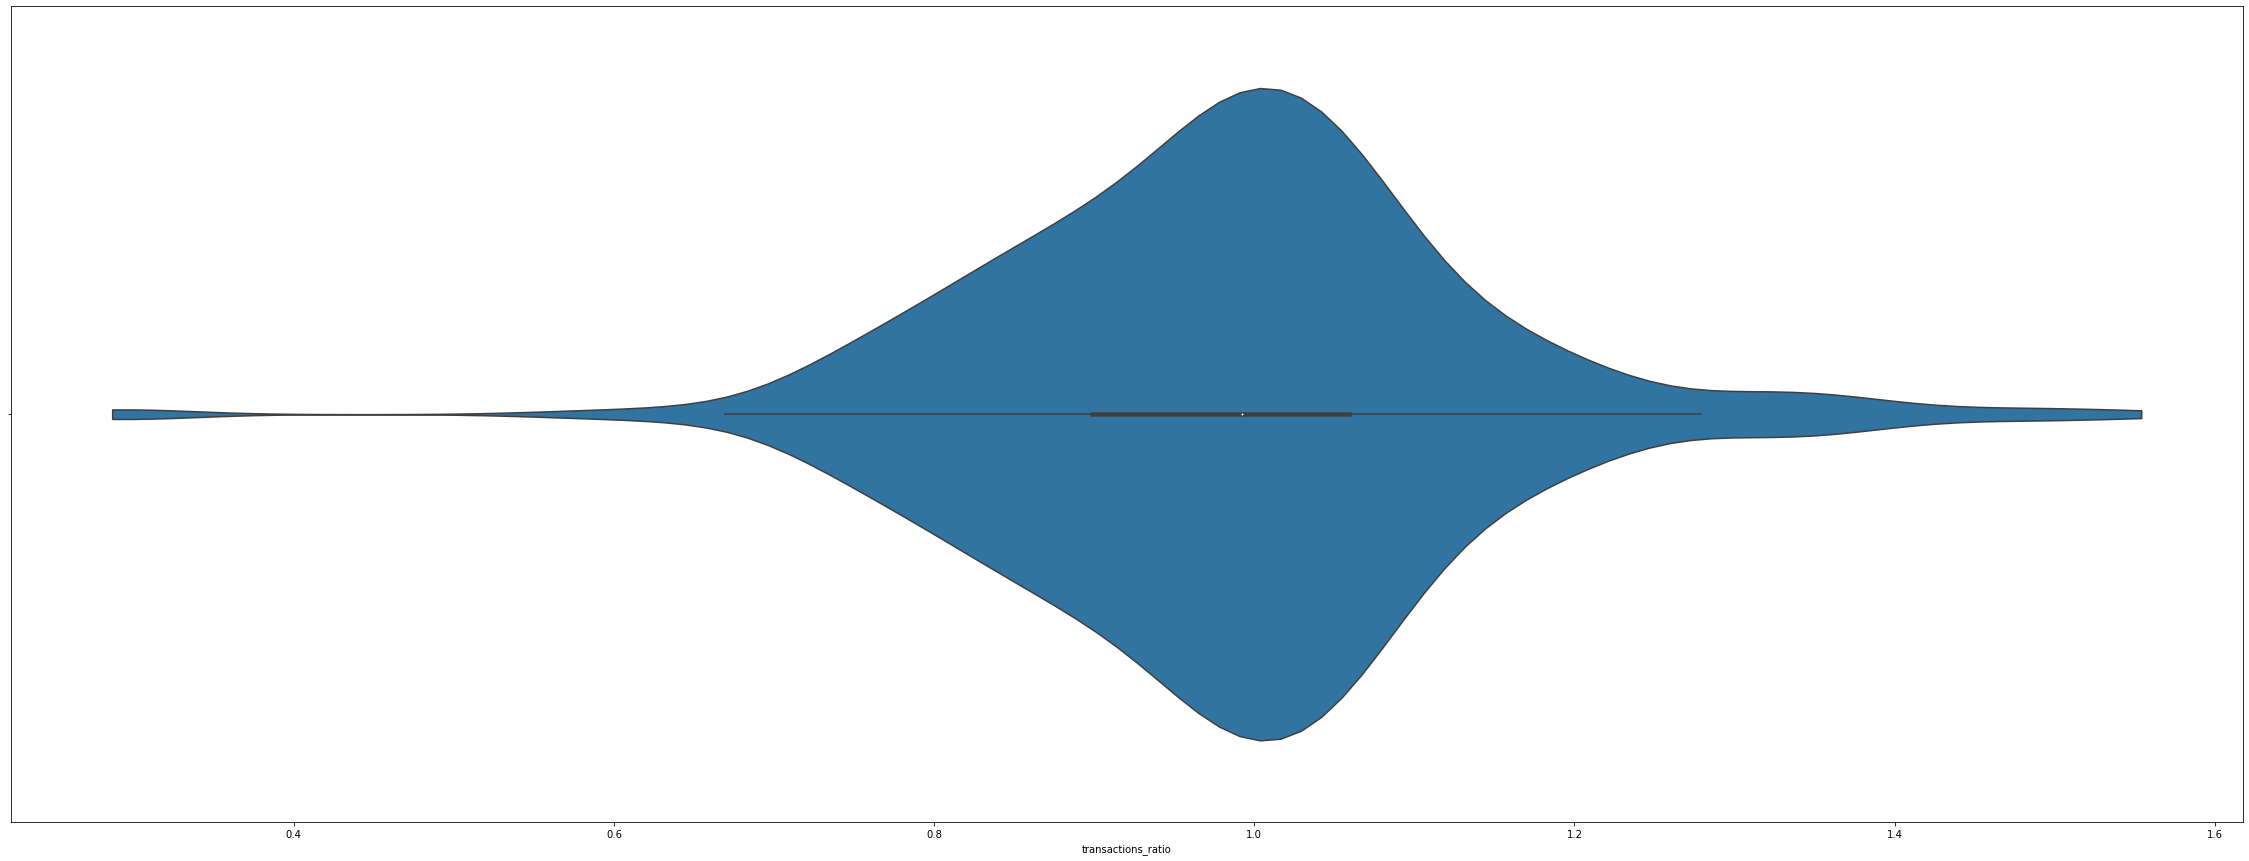

In [203]:
fig, axes = plt.subplots(figsize = (40, 15))

sns.violinplot(holidays_impact.transactions_ratio, cut = 0)

In [24]:
holidays_impact.groupby('holiday').transactions_ratio.mean().sort_values()

holiday
Provincializacion Santa Elena         0.783489
Cantonizacion de Quevedo              0.845795
Cantonizacion de Cayambe              0.871058
Fundacion de Santo Domingo            0.887234
Fundacion de Guayaquil-1              0.890912
Cantonizacion de Riobamba             0.897351
Fundacion de Ibarra                   0.910061
Fundacion de Riobamba                 0.916278
Fundacion de Guayaquil                0.923037
Fundacion de Machala                  0.923794
Independencia de Latacunga            0.930369
Provincializacion de Santo Domingo    0.934818
Cantonizacion de El Carmen            0.936649
Provincializacion de Imbabura         0.948546
Cantonizacion de Guaranda             0.957161
Fundacion de Manta                    0.958655
Independencia de Ambato               0.965785
Fundacion de Ambato                   0.967362
Cantonizacion de Latacunga            0.973668
Fundacion de Cuenca                   0.996406
Fundacion de Esmeraldas               0.997853
Canto

Text(0.5, 1.0, 'Ratio between number of transactions during holidays \n and normal days for different days of week \n for holiday Provincializacion de Cotopaxi')

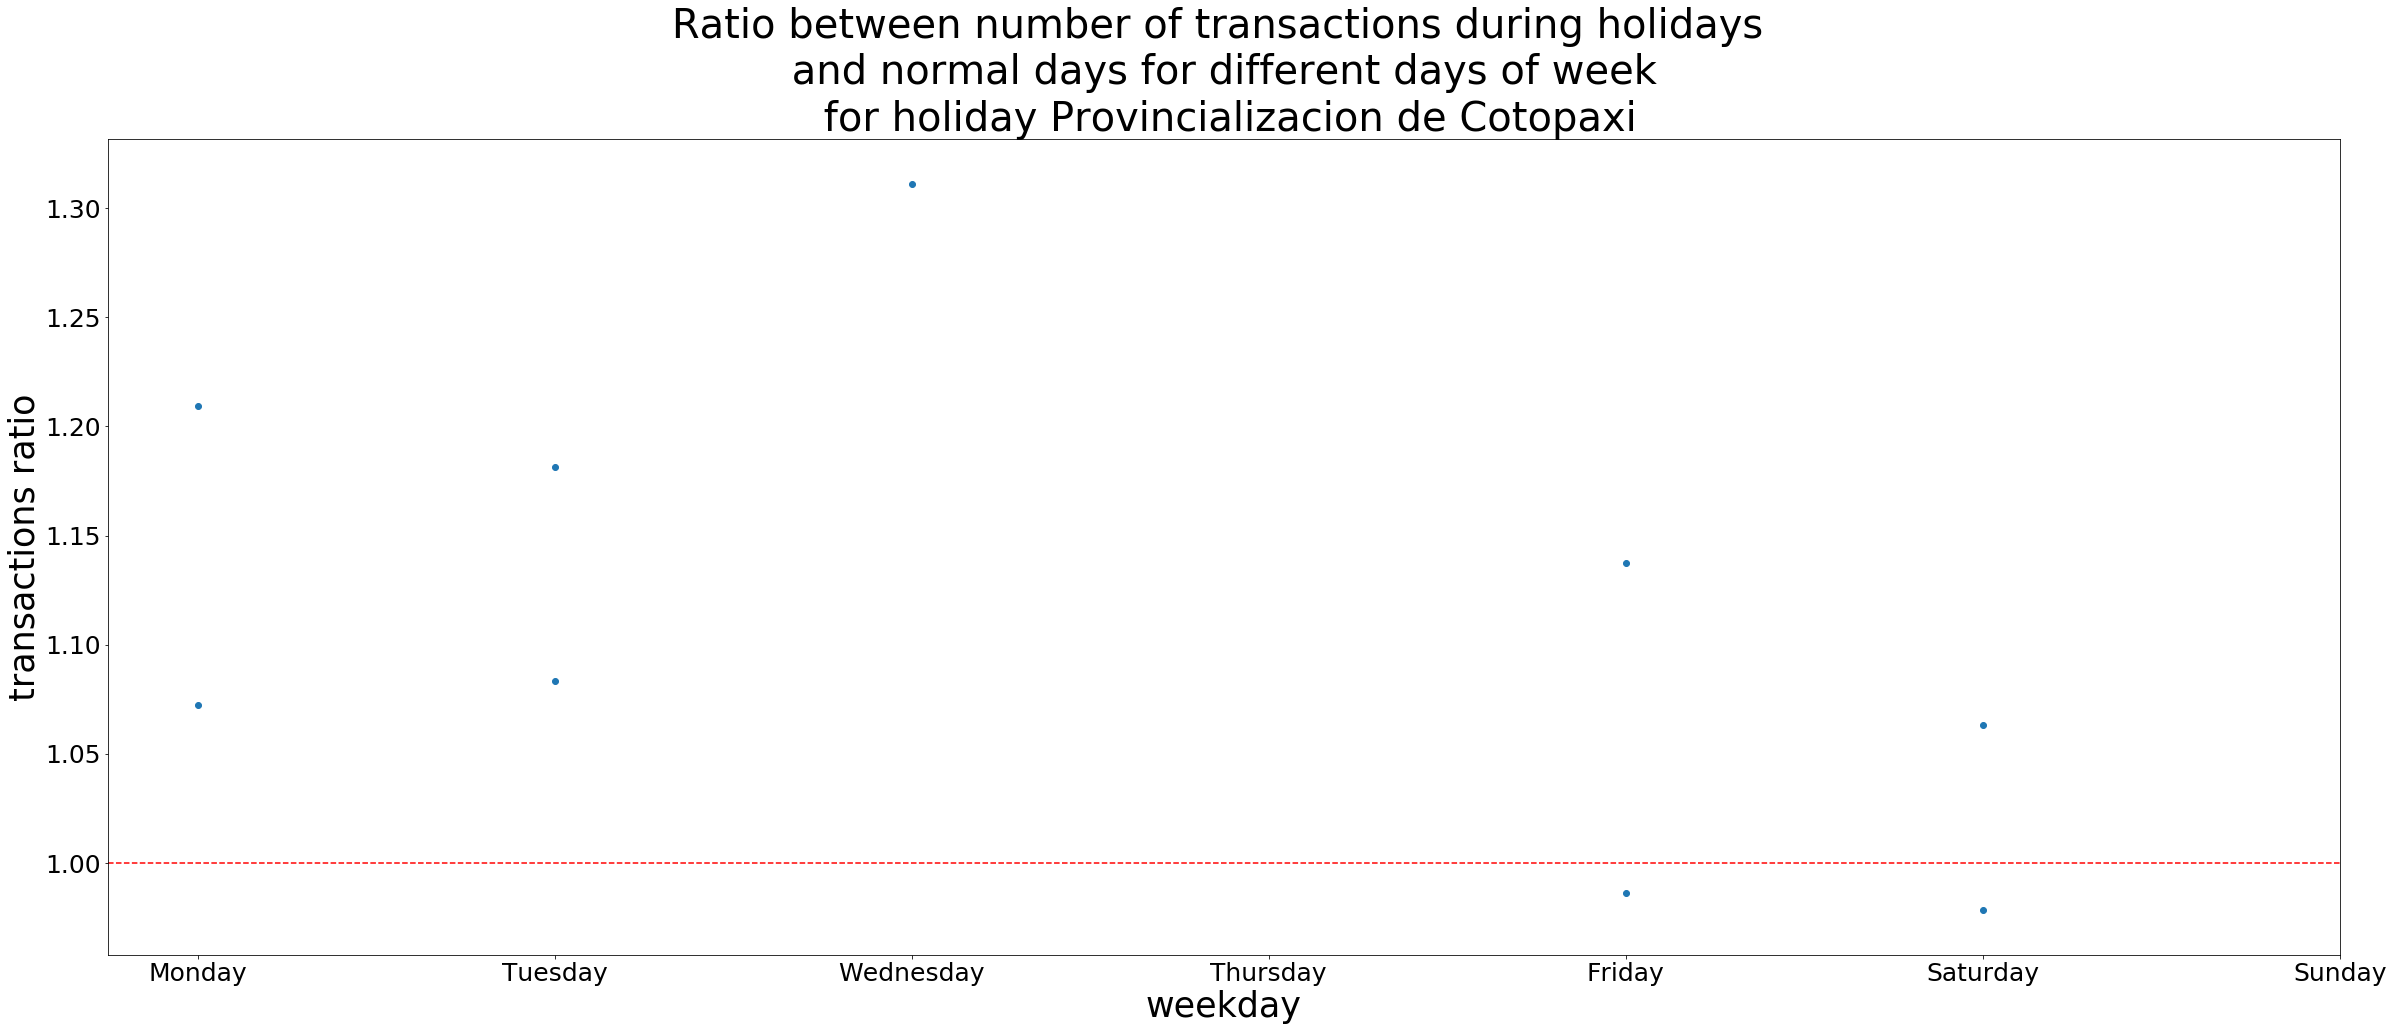

In [32]:
fig, axes = plt.subplots(figsize = (40, 15))

holiday = 'Provincializacion de Cotopaxi'
df = holidays_impact[holidays_impact.holiday == holiday]

y = df.transactions_ratio.values
x = df.weekday.values

axes.scatter(x, y)
axes.axhline(1, color = 'red', ls = '--')

axes.set_xlabel('weekday', fontsize = 35)
axes.set_ylabel('transactions ratio', fontsize = 35)

axes.tick_params(axis = 'both', labelsize = 25)

axes.set_xticks([0,1,2,3,4,5,6])
axes.set_xticklabels(np.array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']))

axes.set_title(f'Ratio between number of transactions during holidays \n and normal days for different days of week \n for holiday {holiday}', fontsize = 40)

In [36]:
# using chi square test to test if there is relation between holidays and number of transactions
# p-value is propability of obtaining observations in df assuming H0 that transactions and holiday are independent variables

column = 'holiday'
df = transactions[['transactions', column]]

def round_to_100(x):
    if x % 100 < 50:
        x -= x % 100
    else:
        x += 100 - x % 100
        
    return x

df['transactions'] = df.transactions.apply(lambda x: round_to_100(x))
df['holiday'] = df.holiday.apply(lambda x: 0 if x == 'none' else 1)
# df = df[df.holiday != 'none']

df_crosstab = pd.crosstab(df['transactions'],
                          df[column],
                          margins=True, margins_name="Total")

chi_square = 0
rows = df['transactions'].unique()
columns = df[column].unique()

for i in columns:
    for j in rows:
        O = df_crosstab[i][j]
        E = df_crosstab[i]['Total'] * df_crosstab['Total'][j] / df_crosstab['Total']['Total']
        chi_square += (O-E)**2/E

print(chi_square)
print((len(rows) - 1) * (len(columns) - 1))

p_value = 1 - stats.chi2.cdf(chi_square, (len(rows) - 1) * (len(columns) - 1))

print(p_value)

101.3251376644313
82
0.07274348743053616


C:\Users\mbulk\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\mbulk\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


## relatonship between holidays and oil price

In [40]:
oil = pd.read_csv('data/oil.csv')

In [38]:
## creating weekly_transactions table

weekly_transactions = pd.DataFrame()
df = transactions.sort_values('date').reset_index(drop = True)
i = 0
pbar = tqdm(total = len(transactions))
update_cycle = 10000

while i < len(df):
    start_date = df.loc[i, 'date']
    end_date = start_date + timedelta(days = 6)
    
    df_week = df[df.date.apply(lambda x: start_date <= x <= end_date)]
    week_transactions = df_week.transactions.sum()
    
    if df_week.date.iloc[-1] - df_week.date.iloc[0] == timedelta(days = 6):
        weekly_transactions = pd.concat((weekly_transactions, pd.DataFrame({'start_date': [start_date], 'end_date': [end_date], 'transactions': [week_transactions]})))
        
    if i >= update_cycle:
        update_cycle += 10000
        pbar.update(10000)
    
    i = df_week.index[-1] + 1
                                 
pbar.close()
weekly_transactions.reset_index(drop = True, inplace = True)

 96%|██████████████████████████████████████████████████████████████████████▉   | 80000/83487 [00:57<00:02, 1392.14it/s]


In [335]:
weekly_transactions.head()

,start_date,end_date,transactions
0,2013-01-02,2013-01-08,582172
1,2013-01-09,2013-01-15,521721
2,2013-01-16,2013-01-22,528792
3,2013-01-23,2013-01-29,514947
4,2013-01-30,2013-02-05,555367


Text(0.5, 1.0, 'oil price')

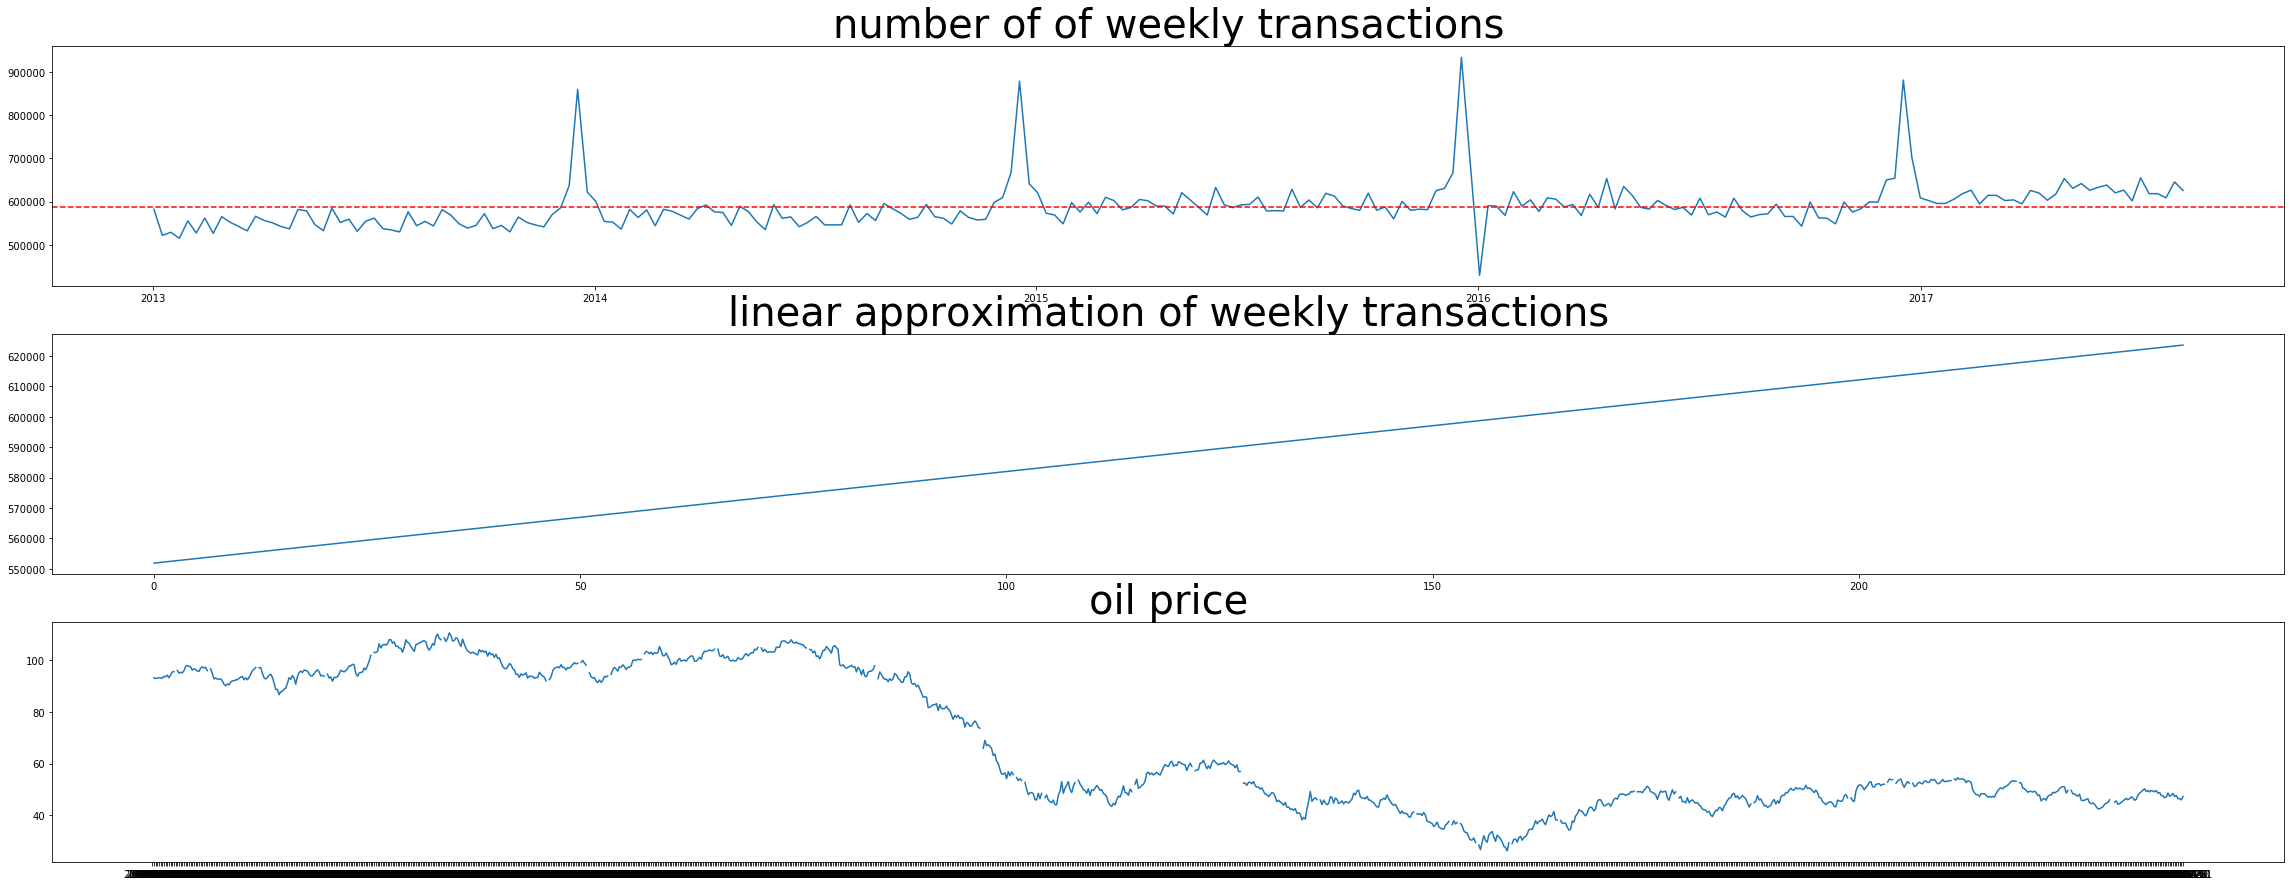

In [43]:
fig, axes = plt.subplots(figsize = (40, 15), nrows = 3)

y = weekly_transactions.transactions
x = np.arange(len(y))
a, b = np.polyfit(x, y, 1)
lin_approx = [a * i + b for i in range(len(y))]

# axes[0].plot(daily_transactions.date, daily_transactions.transactions)
axes[0].plot(weekly_transactions.start_date, weekly_transactions.transactions)
axes[0].axhline(weekly_transactions.transactions.mean(), color = 'red', ls = '--')
axes[1].plot(lin_approx)
axes[2].plot(oil.iloc[:, 0], oil.iloc[:, 1])

axes[0].set_title('number of weekly transactions', fontsize = 40)
axes[1].set_title('linear approximation of weekly transactions', fontsize = 40)
axes[2].set_title('oil price', fontsize = 40)

## comparison of the number of transactions for different years

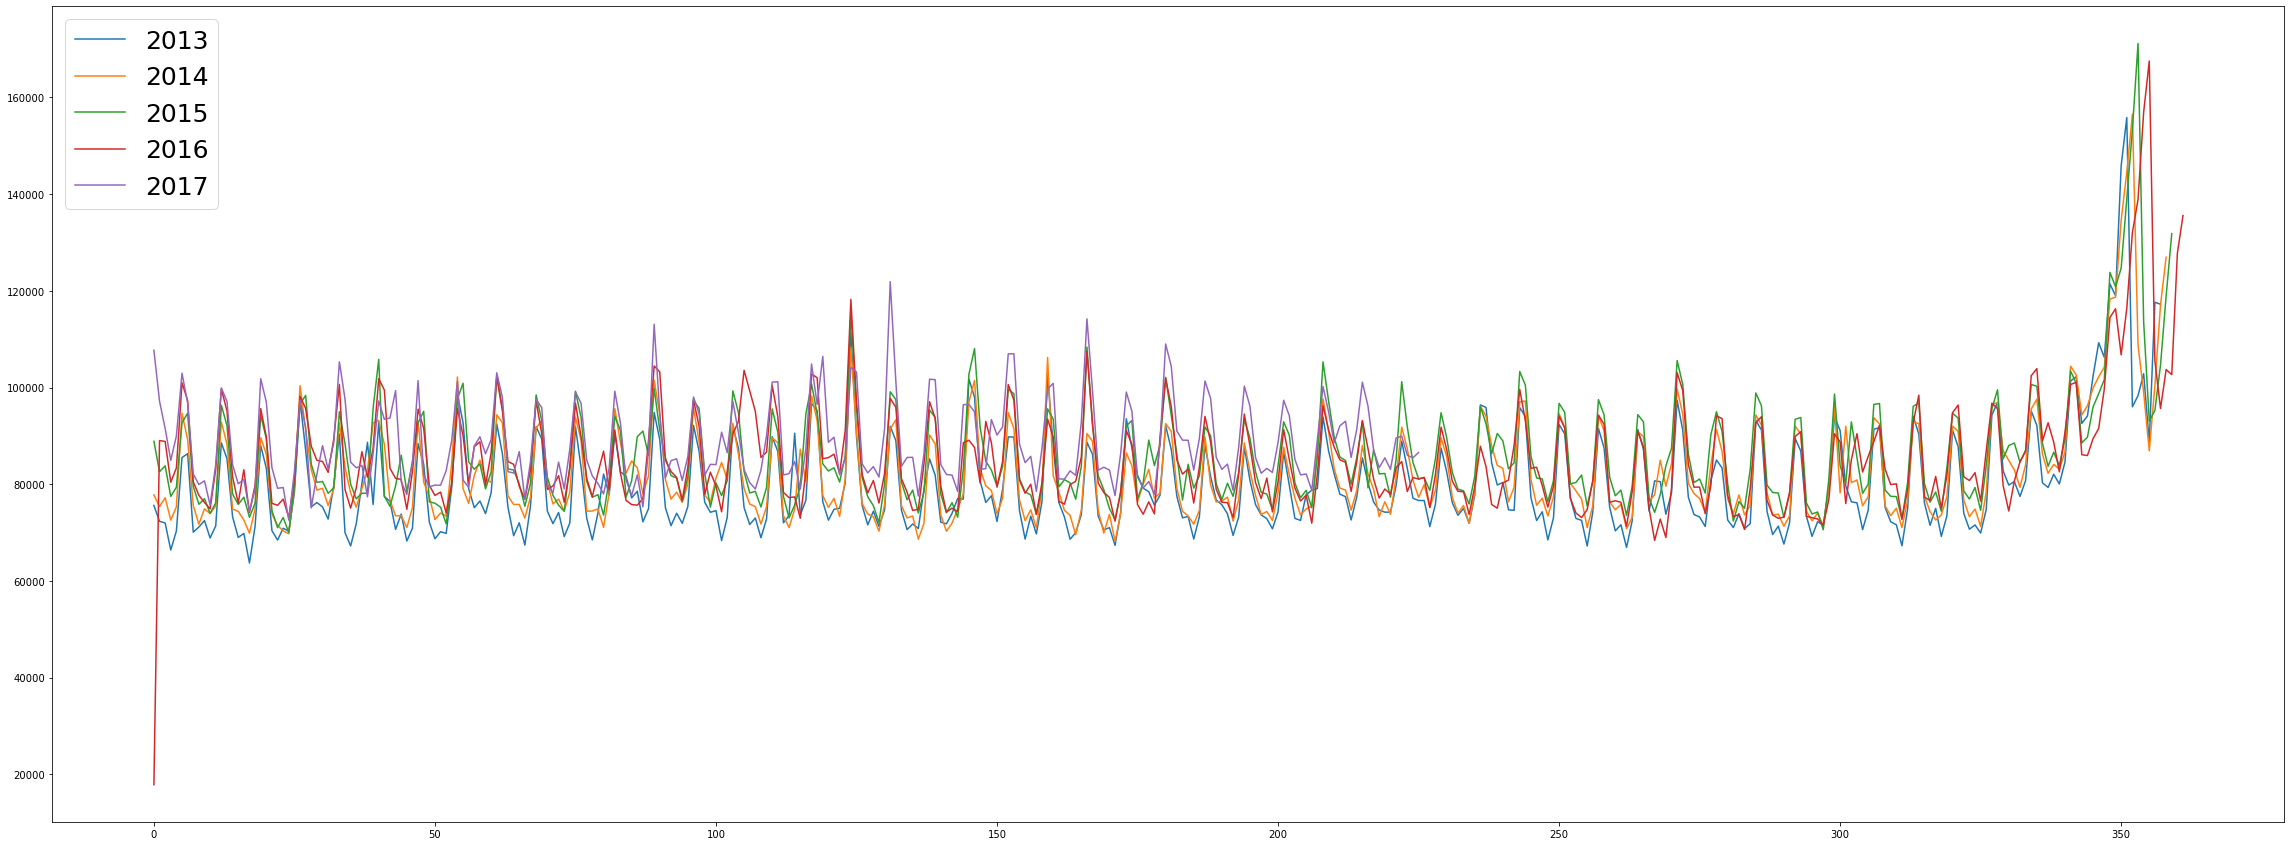

In [42]:
# comparison of daily transactions for 5 different years

fig, axes = plt.subplots(figsize = (40, 15), nrows = 1)

daily_transactions = transactions.groupby('date').transactions.sum().reset_index()
daily_transactions['weekday'] = daily_transactions.date.apply(lambda x: x.weekday())

for i in range(5):
    df = daily_transactions[daily_transactions.date.apply(lambda x: x.year == 2013 + i)]
    
    # we want data for every year to start at the same weekday which is 0
    while df.weekday.iloc[0] != 0:
        df.drop(df.index[0], inplace = True)
    
    y = df.transactions
    x = np.arange(len(y))
    
    axes.plot(x, y, label = 2013 + i)
    
axes.legend(fontsize = 25)

Text(0, 0.5, 'transactions')

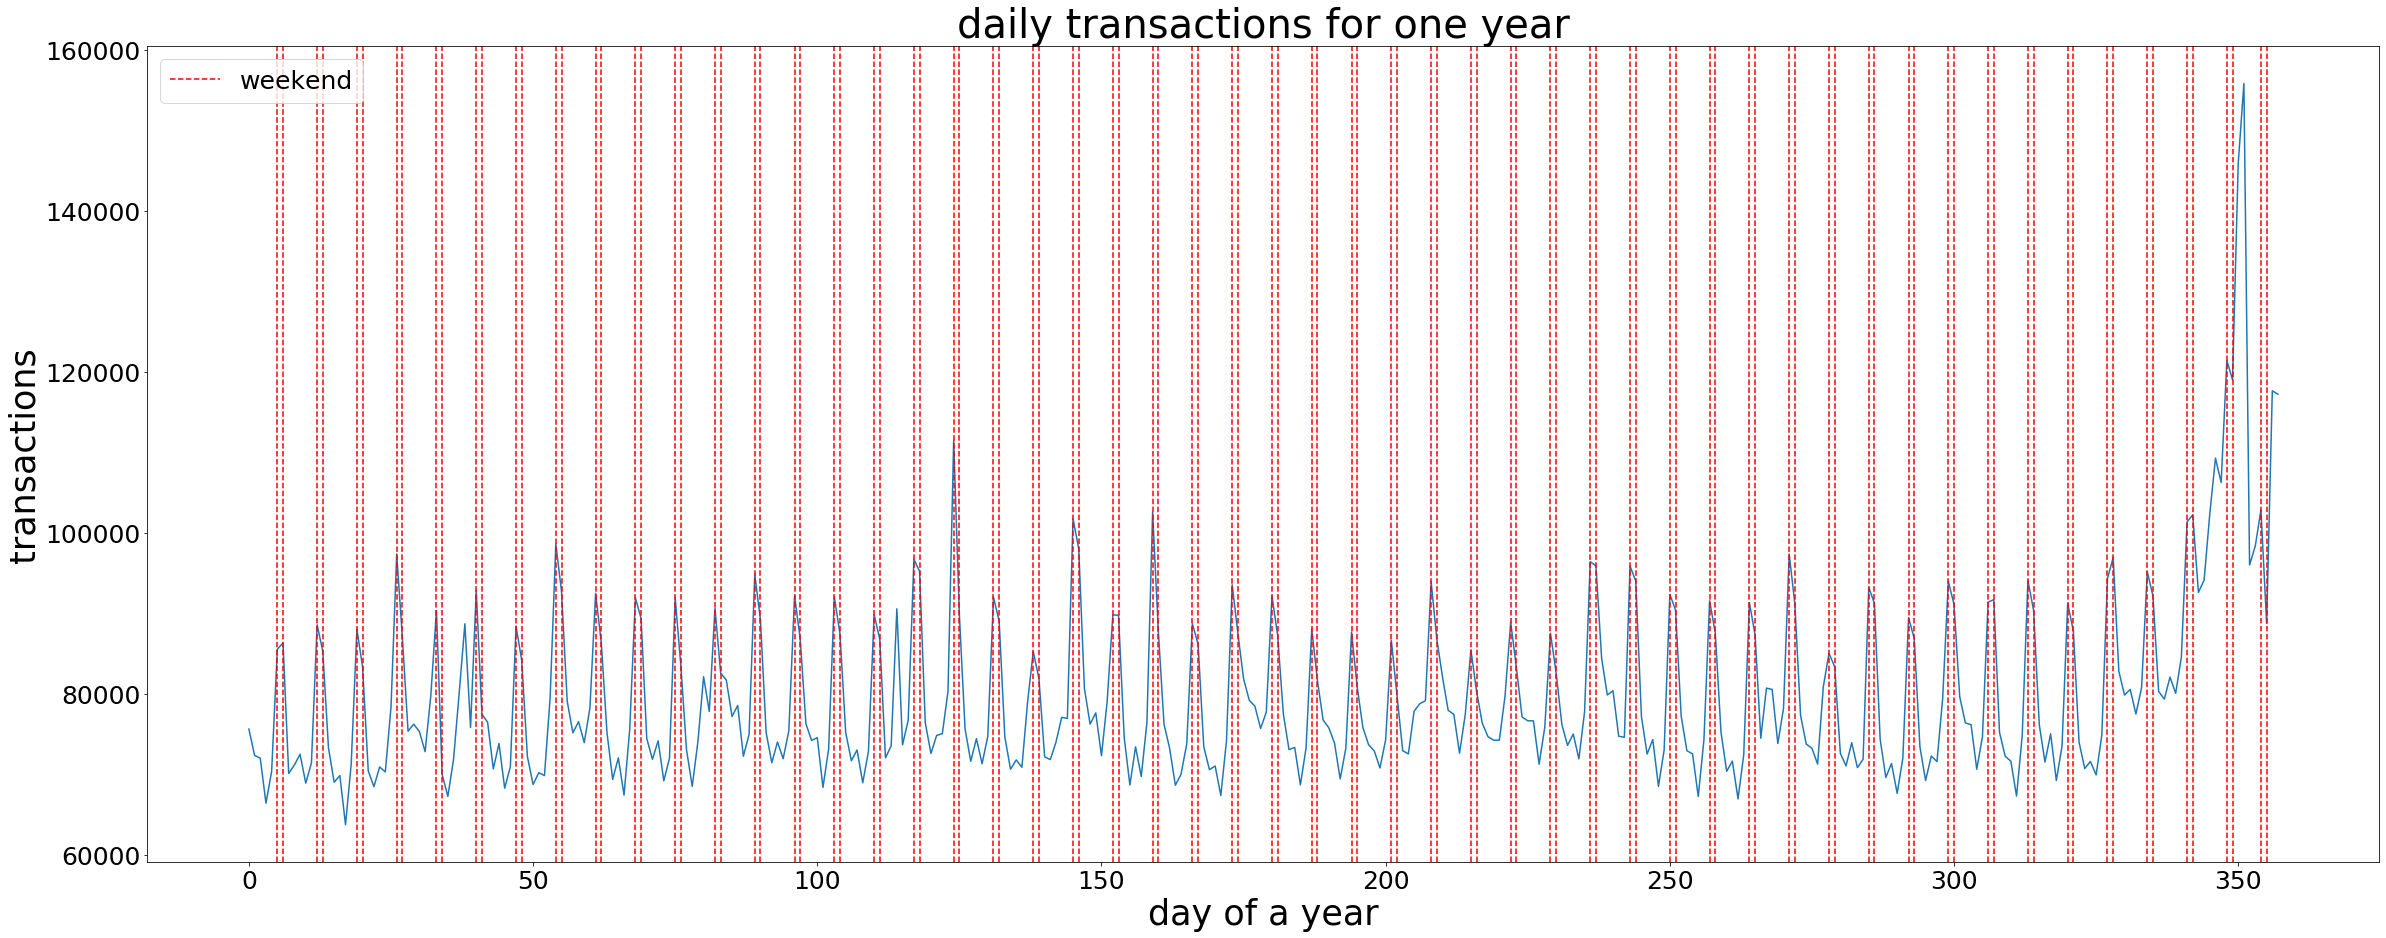

In [52]:
fig, axes = plt.subplots(figsize = (40, 15), nrows = 1)

daily_transactions = transactions.groupby('date').transactions.sum().reset_index()
daily_transactions['weekday'] = daily_transactions.date.apply(lambda x: x.weekday())

df = daily_transactions[daily_transactions.date.apply(lambda x: x.year == 2013)]
while df.weekday.iloc[0] != 0:
    df.drop(df.index[0], inplace = True)
    
y = df.transactions
x = np.arange(len(y))

axes.plot(x, y)
    
weekdays = df.weekday.values
weekend_indexes = np.where((weekdays == 5) | (weekdays == 6))[0]

for iteration, index in enumerate(weekend_indexes):
    if iteration == 0:
        axes.axvline(index, color = 'red', ls = '--', label = 'weekend')
    else:
        axes.axvline(index, color = 'red', ls = '--')
        
axes.legend(fontsize = 25)
axes.set_title('daily transactions for one year', fontsize = 40)
axes.tick_params(labelsize = 25)
axes.set_xlabel('day of a year', fontsize = 35)
axes.set_ylabel('transactions', fontsize = 35)

No handles with labels found to put in legend.


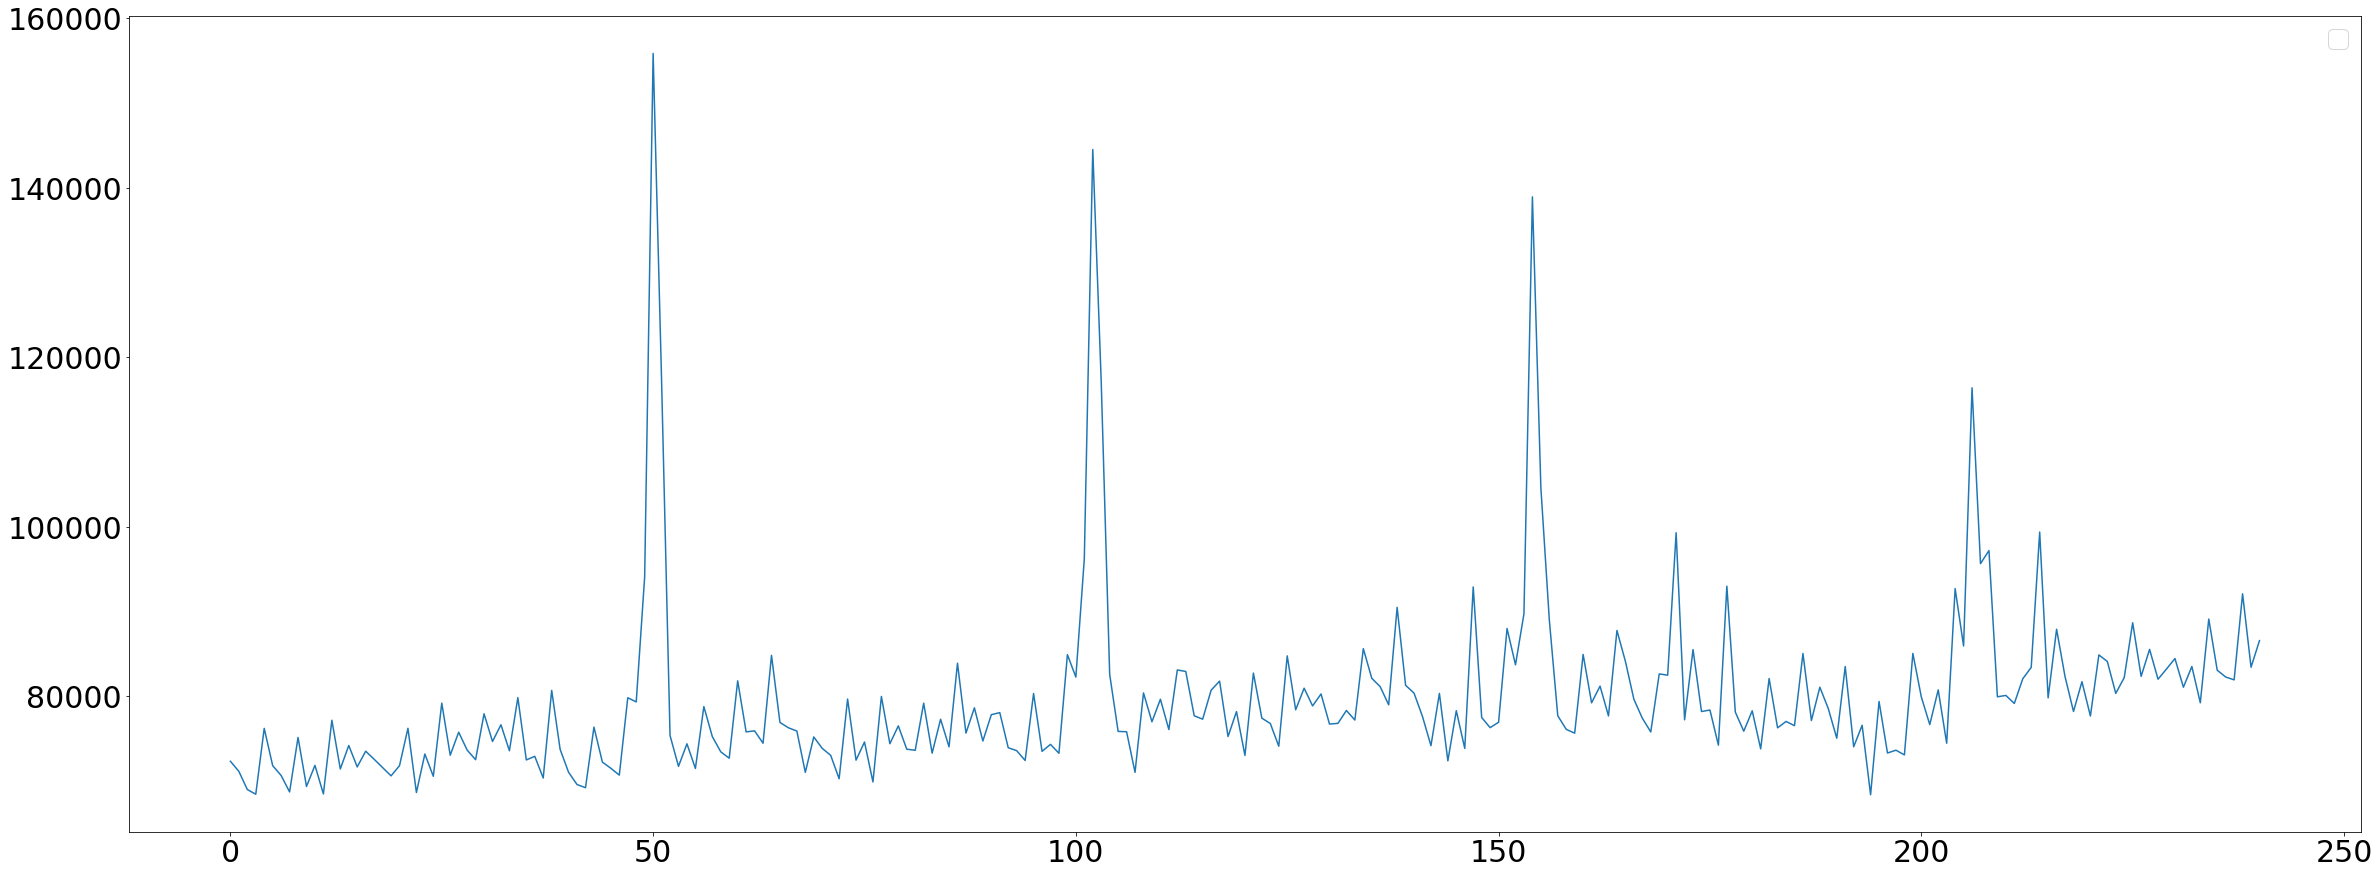

In [66]:
# number of daily transactions for different weekdays

weekday = 1

fig, axes = plt.subplots(figsize = (40, 15), nrows = 1)

daily_transactions = transactions.groupby('date').transactions.sum().reset_index()
daily_transactions['weekday'] = daily_transactions.date.apply(lambda x: x.weekday())

transactions_for_weekday = daily_transactions[daily_transactions.weekday == weekday]

y = transactions_for_weekday.transactions
x = np.arange(len(y))

axes.plot(x, y)
    
axes.legend(fontsize = 25)
axes.tick_params(labelsize = 30)

In [87]:
# standard deviation of daily transactions for different weekdays and stores

stds = pd.DataFrame()

def check_christmas(date):
    if date.month == 12 and (date.day in range(22, )

for store_nbr in range(1, transactions.store_nbr.nunique() + 1):
    for weekday in range(7):
        df = transactions[transactions.store_nbr == store_nbr]
        df = df[df.weekday == weekday]
        stds = pd.concat((stds, pd.DataFrame([[store_nbr, weekday, np.std(df.transactions)]])))
                          
stds.columns = ['store_nbr', 'weekday', 'transactions_std']
stds

IndentationError: expected an indented block (Temp/ipykernel_8028/1403732401.py, line 7)

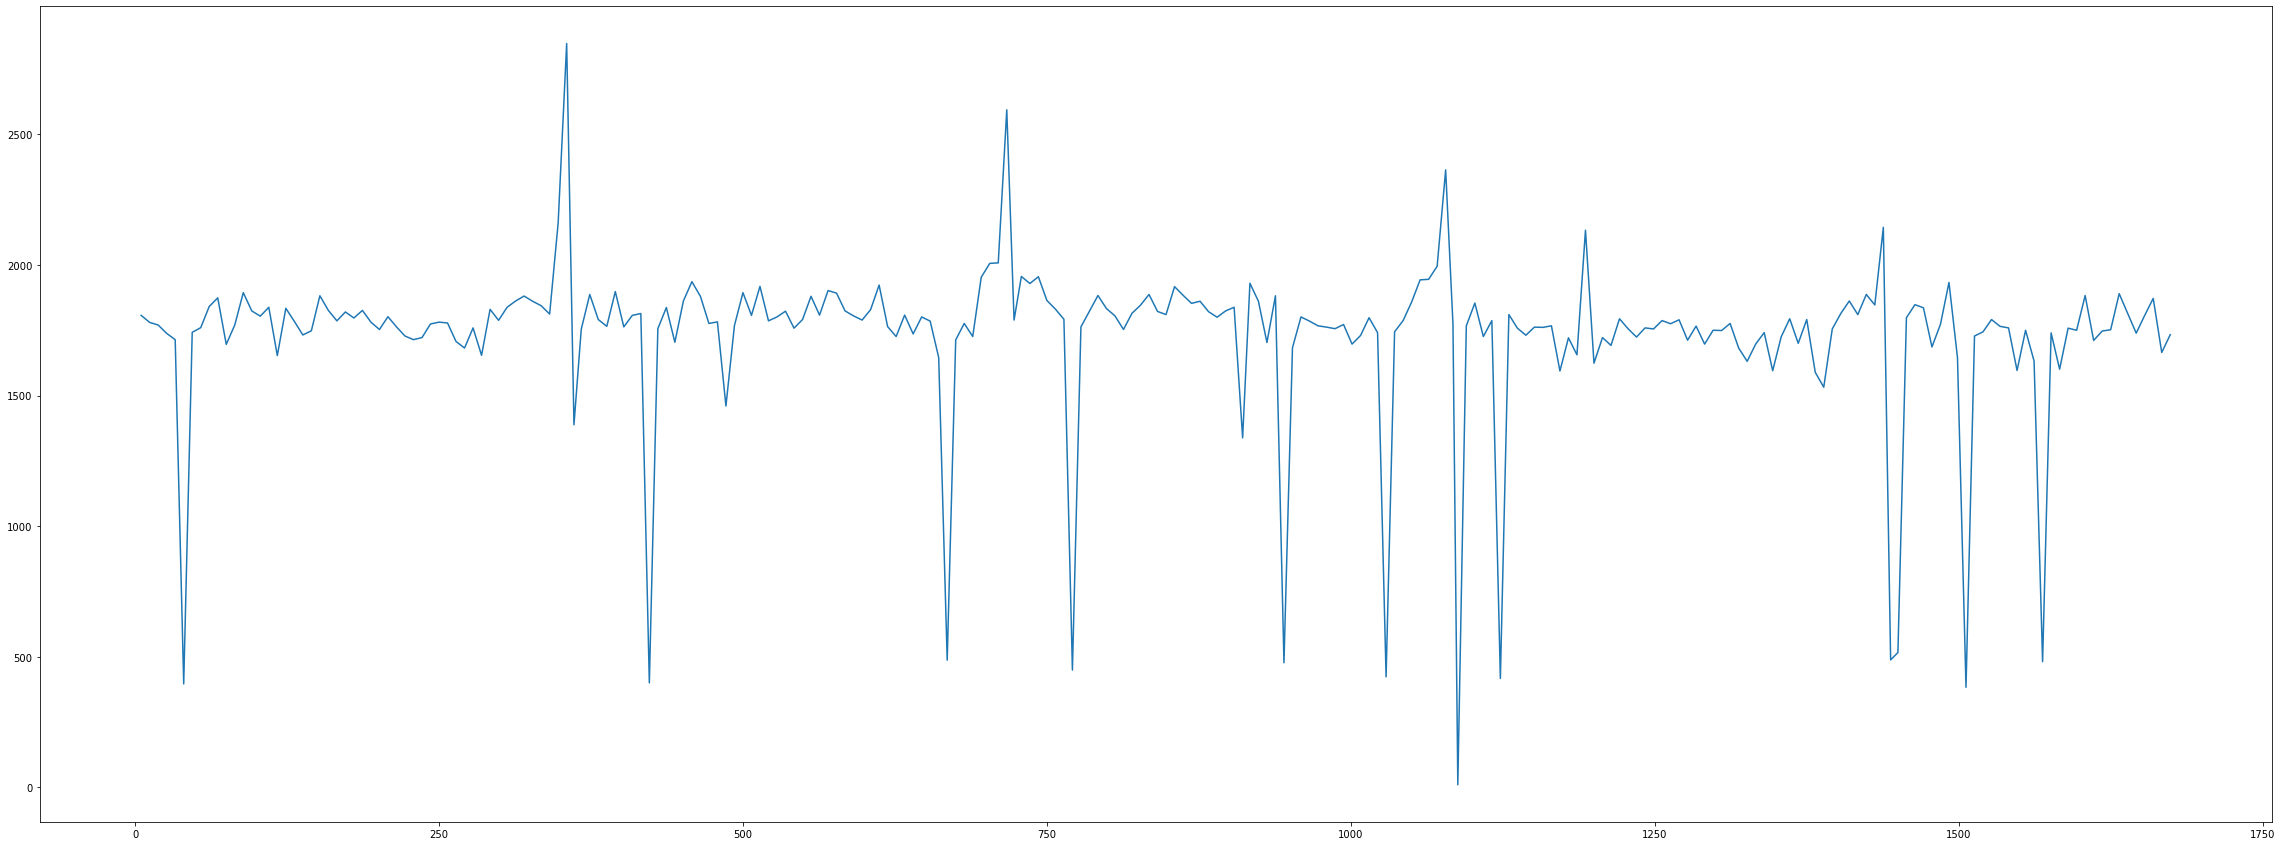

In [86]:
fig, axes = plt.subplots(figsize = (40, 15)) 

axes.plot(transactions[(transactions.store_nbr == 1) & (transactions.weekday == 0)].transactions)

In [178]:
# days with number of transactions much bigger or smaller than usual
# keys of outstanding_dates are store numbers and values has format [day, month]

store_nbrs = transactions.store_nbr.unique()
outstanding_dates = {k: [] for k in store_nbrs}

for store_nbr in store_nbrs:
    # for weekday in range(7):
    df = transactions[transactions.store_nbr == store_nbr]
    # df = df[df.weekday == weekday]

    # mean_transactions = df.transactions.mean()
    # dates = df[df.transactions.apply(lambda x: x / mean_transactions > 1.5 or x / mean_transactions < 0.5)].date.values
    lower_threshold = df.transactions.sort_values(ascending = False).iloc[int(len(df) * 0.95)]
    upper_threshold = df.transactions.sort_values().iloc[int(len(df) * 0.95)]
    dates = df[df.transactions.apply(lambda x: x < lower_threshold * 0.8 or x > upper_threshold * 1.2)].date.values
    dates = [[pd.Timestamp(date).day, pd.Timestamp(date).month] for date in dates]

    for date in dates:
        if date not in outstanding_dates[store_nbr]:
            outstanding_dates[store_nbr].append(date)

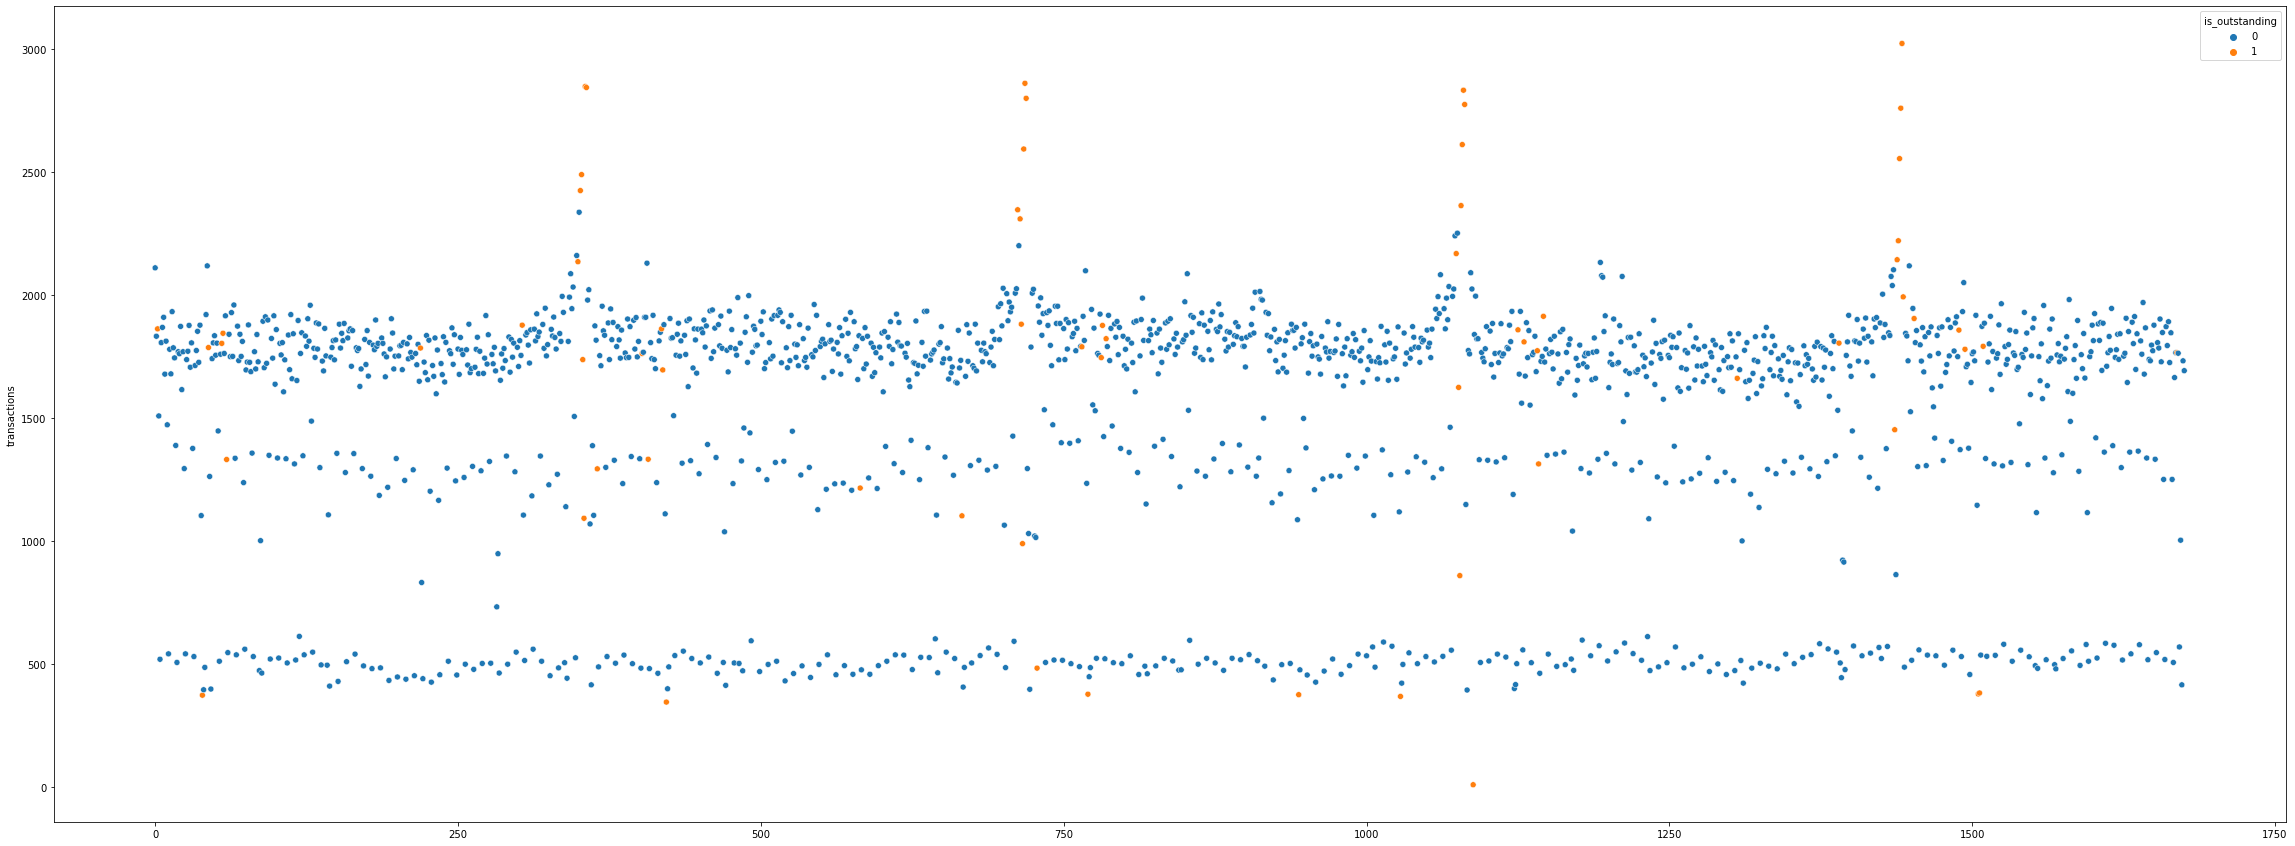

In [180]:
fig, axes = plt.subplots(figsize = (40, 15))

store_nbr = 1
df = transactions[transactions.store_nbr == store_nbr][['transactions', 'date']]
df['is_outstanding'] = df.date.apply(lambda x: 1 if [x.day, x.month] in outstanding_dates[store_nbr] else 0)

sns.scatterplot(x = np.arange(len(df)), y = 'transactions', data = df, hue = 'is_outstanding')

C:\Users\mbulk\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



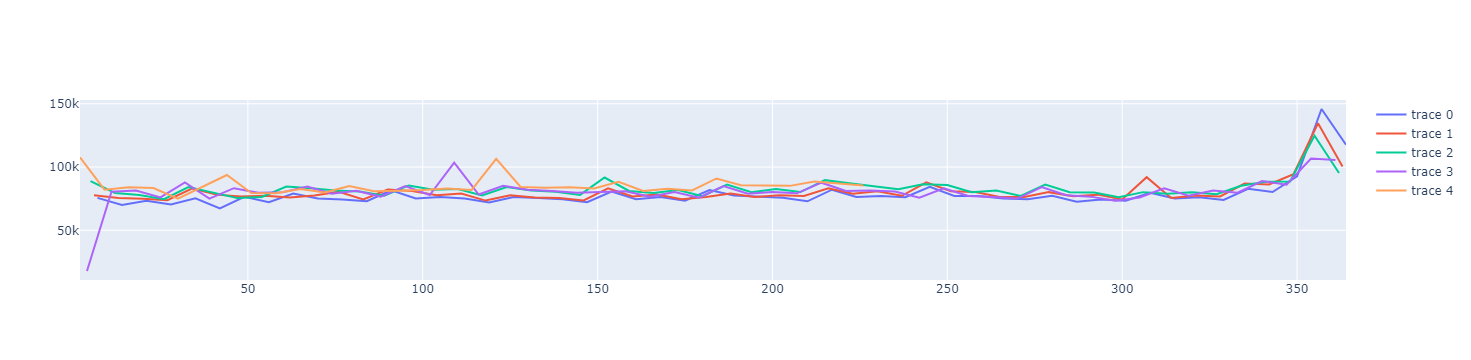

In [80]:
# comparison of daily transactions for given weekday for 5 different years

fig = make_subplots(rows=1, cols=1)

daily_transactions = transactions.groupby('date').transactions.sum().reset_index()
daily_transactions['weekday'] = daily_transactions.date.apply(lambda x: x.weekday())

transactions_for_weekday = daily_transactions[daily_transactions.weekday == weekday]

for i in range(5):
    df = transactions_for_weekday[transactions_for_weekday.date.apply(lambda x: x.year == 2013 + i)]
    df['day_of_year'] = df.date.apply(lambda x: x.timetuple().tm_yday)
    
    y = df.transactions
    # x = np.arange(len(y))
    x = df.day_of_year
    
    fig.add_trace(go.Scatter(x = x, y = y))#, mode = 'line'))
    
fig.show()

In [73]:
df = transactions_for_weekday.sort_values('transactions', ascending = False).iloc[ : 30]
df = df.set_index('date').join(holidays.set_index('date')[['description', 'locale']]).reset_index()
df['day_of_year'] = df.date.apply(lambda x: x.timetuple().tm_yday)
df

,date,transactions,weekday,description,locale,day_of_year
0,2013-12-16,92585,0,NaN,NaN,350
1,2013-12-23,145876,0,Navidad-2,National,357
2,2013-12-30,117645,0,NaN,NaN,364
3,2014-09-01,87941,0,NaN,NaN,244
4,2014-11-03,91982,0,Independencia de Cuenca,National,307
5,2014-12-01,86943,0,Cyber Monday,National,335
6,2014-12-15,94336,0,NaN,NaN,349
7,2014-12-22,134574,0,Cantonizacion de Salinas,Local,356
8,2014-12-22,134574,0,Navidad-3,National,356
9,2014-12-29,100363,0,NaN,NaN,363


## relation between days of week and number of transactions

In [224]:
transactions.groupby('weekday').transactions.mean()

weekday
0    1635.556903
1    1601.377824
2    1621.497604
3    1549.699882
4    1653.989243
5    1952.675786
6    1847.259706
Name: transactions, dtype: float64

Text(0.5, 1.0, 'distribution of number of transactions for different days of week')

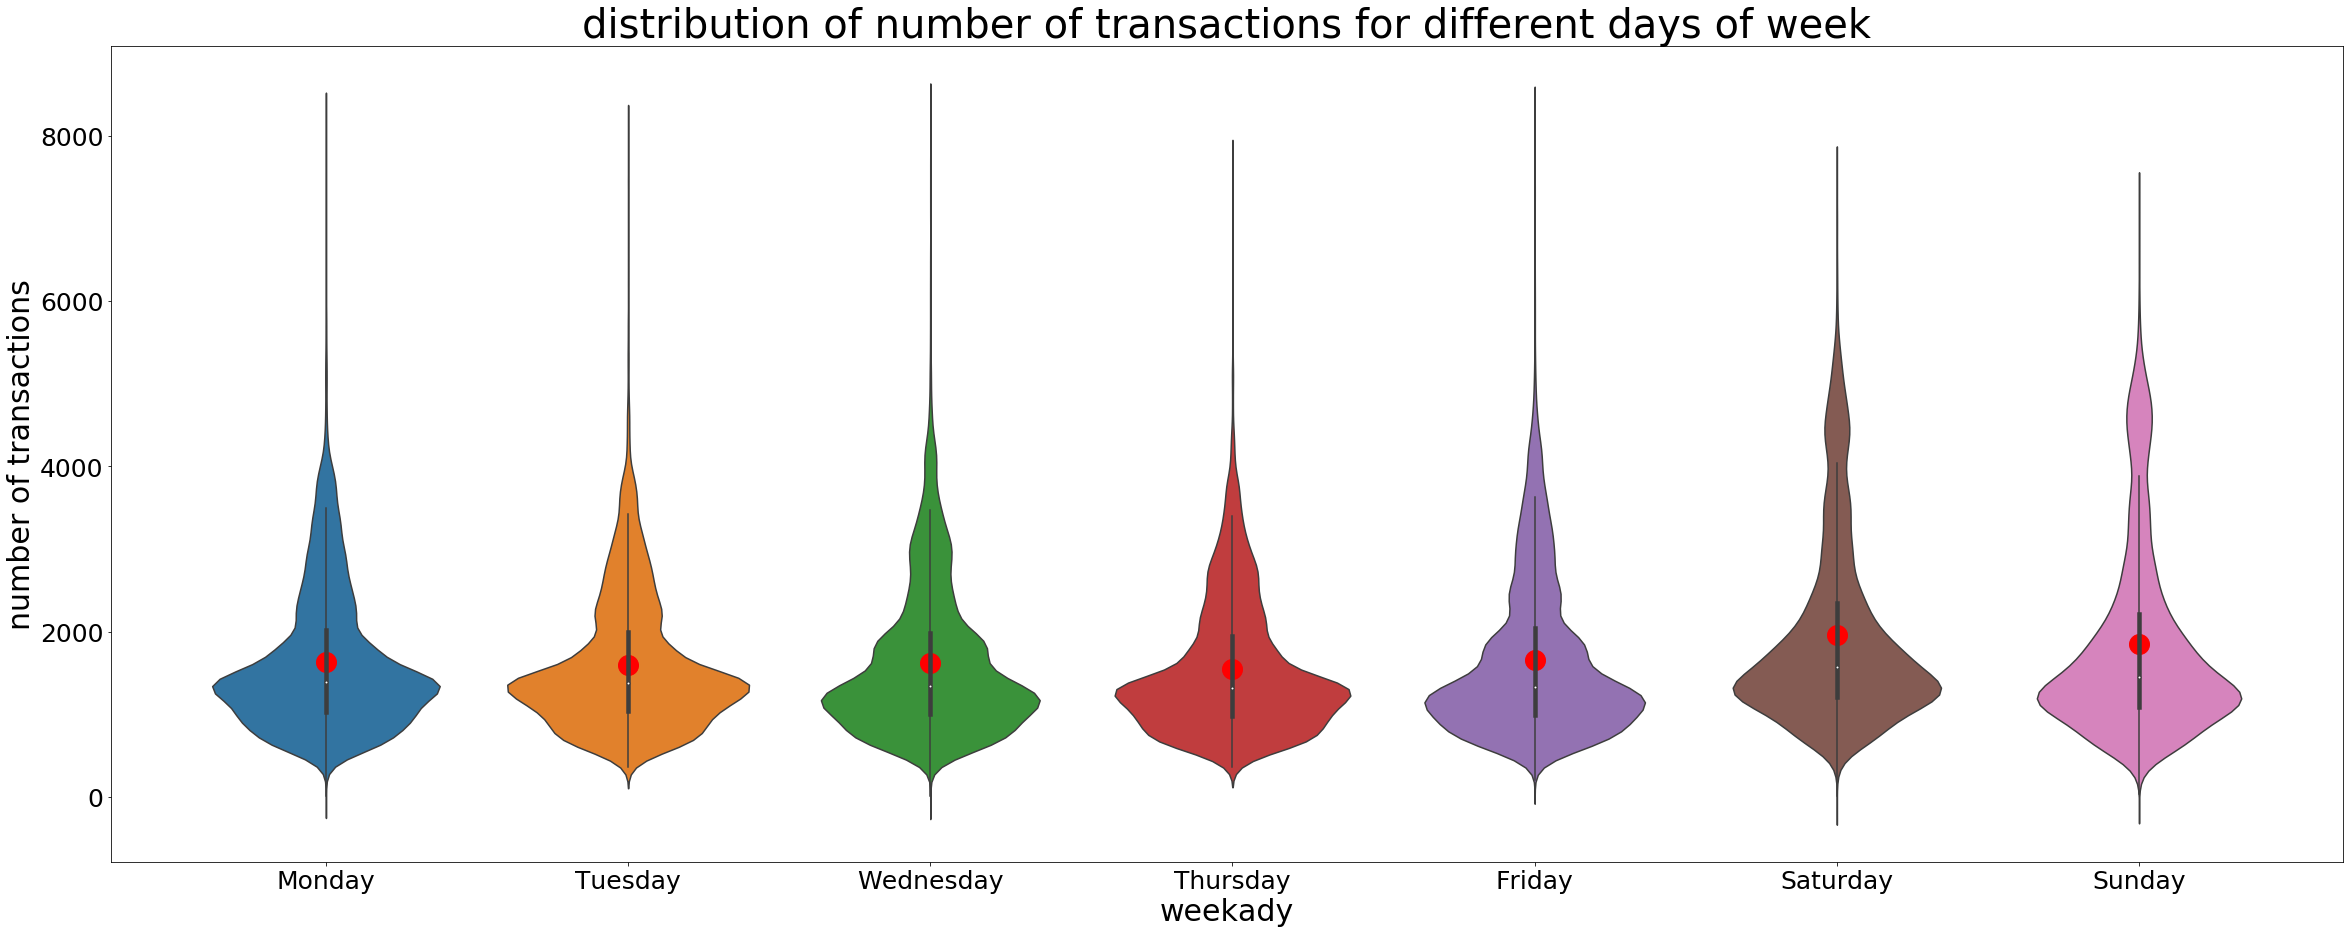

In [241]:
fig, axes = plt.subplots(figsize = (40, 15))

df = transactions.groupby('weekday').transactions.mean()

sns.violinplot(data = transactions, x = 'weekday', y = 'transactions')
axes.scatter(x = df.index, y = df.values, color = 'red', s = 400)

axes.tick_params(axis = 'both', labelsize = 25)
axes.set_xlabel(xlabel = 'weekady', fontsize = 30)
axes.set_ylabel(ylabel = 'number of transactions', fontsize = 30)
axes.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

axes.set_title('distribution of number of transactions for different days of week', fontsize = 40)

## mean number of transactions for different stores

Text(0.5, 1.0, 'distribution of number of transactions for different days of week')

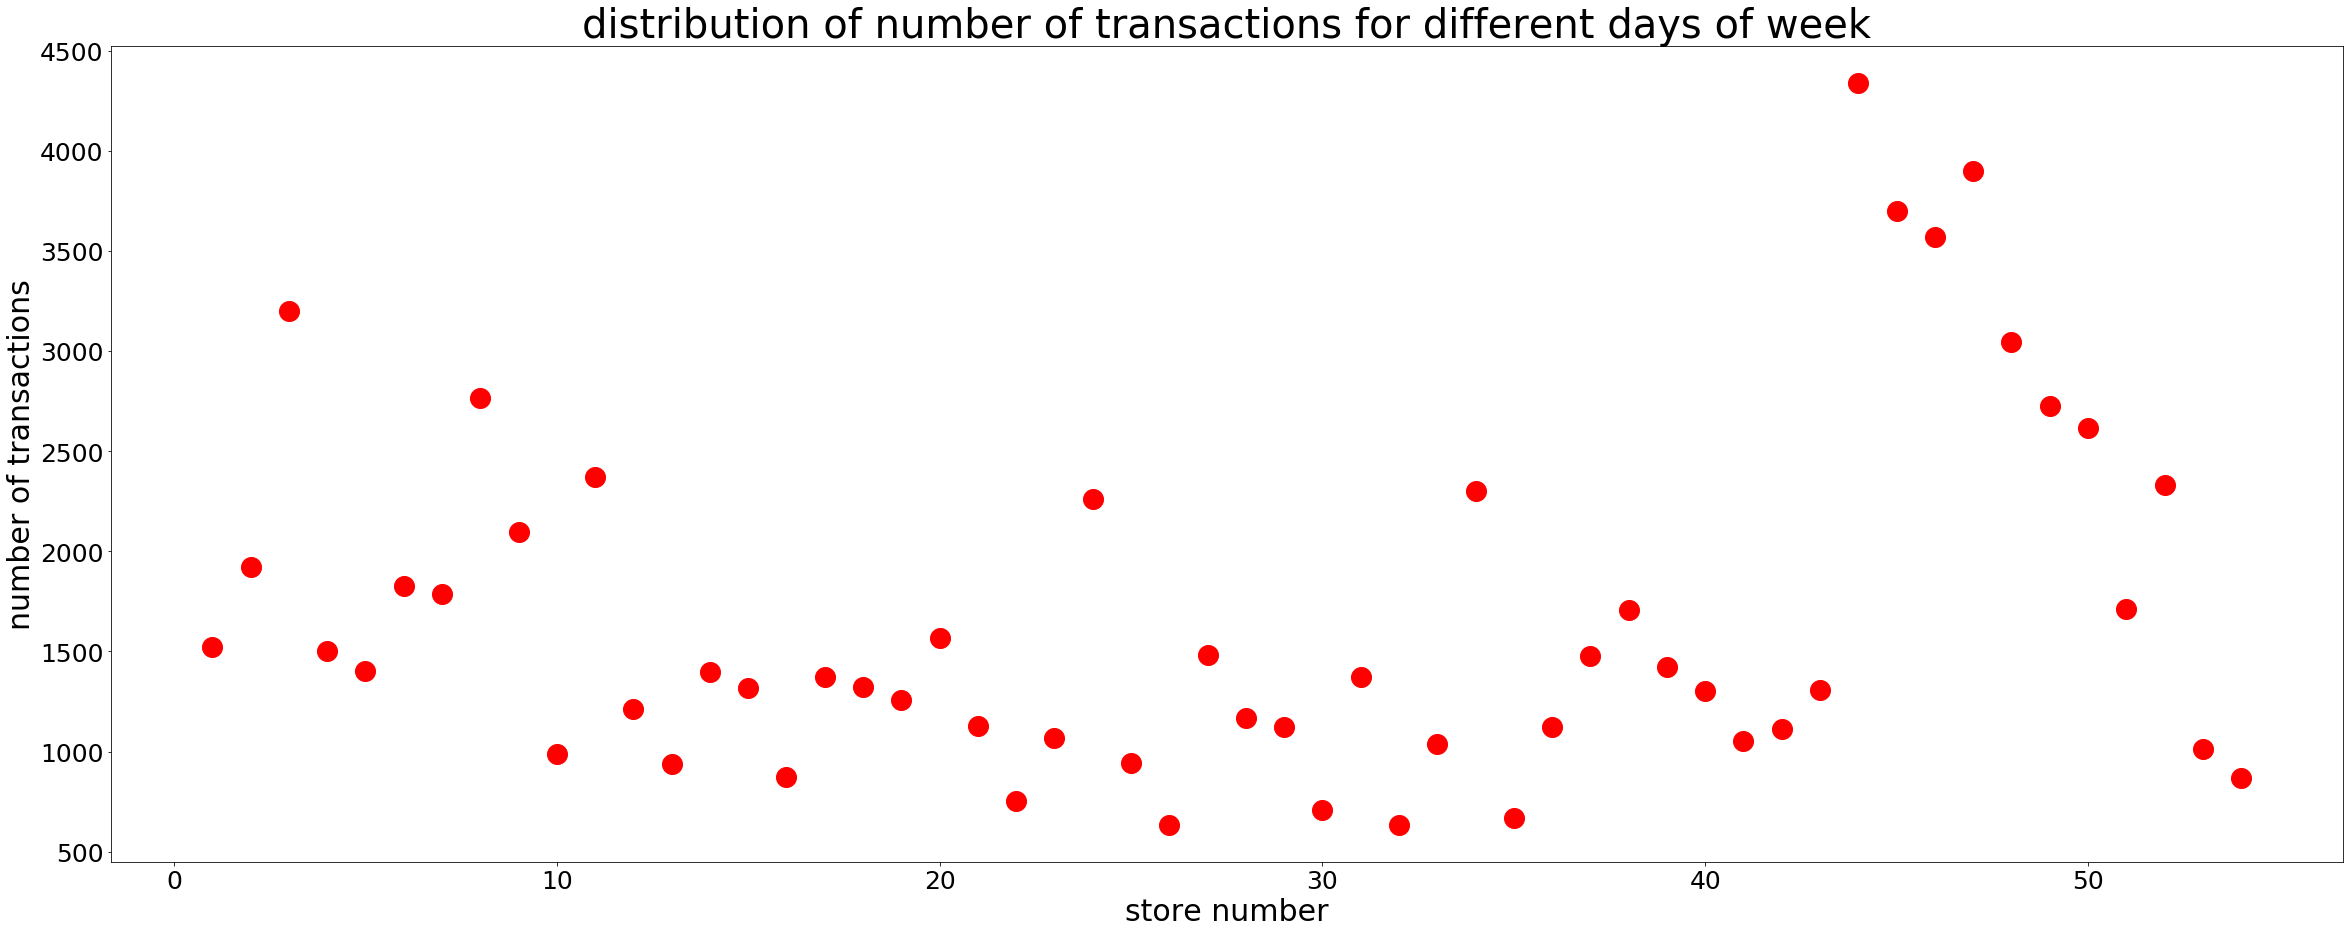

In [244]:
fig, axes = plt.subplots(figsize = (40, 15))

df = transactions.groupby('store_nbr').transactions.mean()

# sns.violinplot(data = transactions, x = 'store_nbr', y = 'transactions')
axes.scatter(x = df.index, y = df.values, color = 'red', s = 400)

axes.tick_params(axis = 'both', labelsize = 25)
axes.set_xlabel(xlabel = 'store number', fontsize = 30)
axes.set_ylabel(ylabel = 'number of transactions', fontsize = 30)
# axes.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

axes.set_title('mean number of transactions for different days of week', fontsize = 40)